In [48]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [49]:
# Functions to display and save images using OpenCV and Matplotlib

def display_image(image: np.ndarray) -> None:
    # Reset the figure
    # plt.clf()

    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()
    # cv2.imwrite(str(path), image)
    # plt.close()

def save_image(image: np.ndarray, path: str|Path) -> None:
    if isinstance(path, Path):
        path = str(path)
    cv2.imwrite(path, image)

In [50]:
# Load images

original = cv2.imread("original.jpg")
brightness = cv2.imread("brightness-2.jpg")
kmeans = cv2.imread("kmeans.png")
dbscan = cv2.imread("dbscan.png")

assert original.shape == brightness.shape == kmeans.shape == dbscan.shape, "All images must have the same shape"

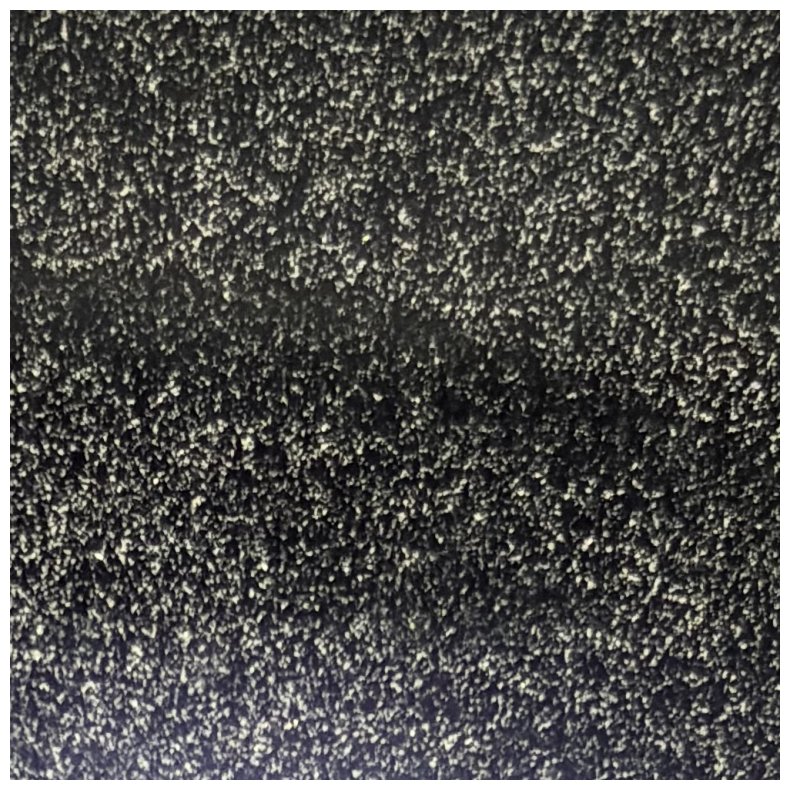

In [51]:
# Choose a region of interest (ROI) in the original image
roi = original[2000:3000, 3000:4000]
# Display the ROI
display_image(roi)
save_image(roi, "roi.png")

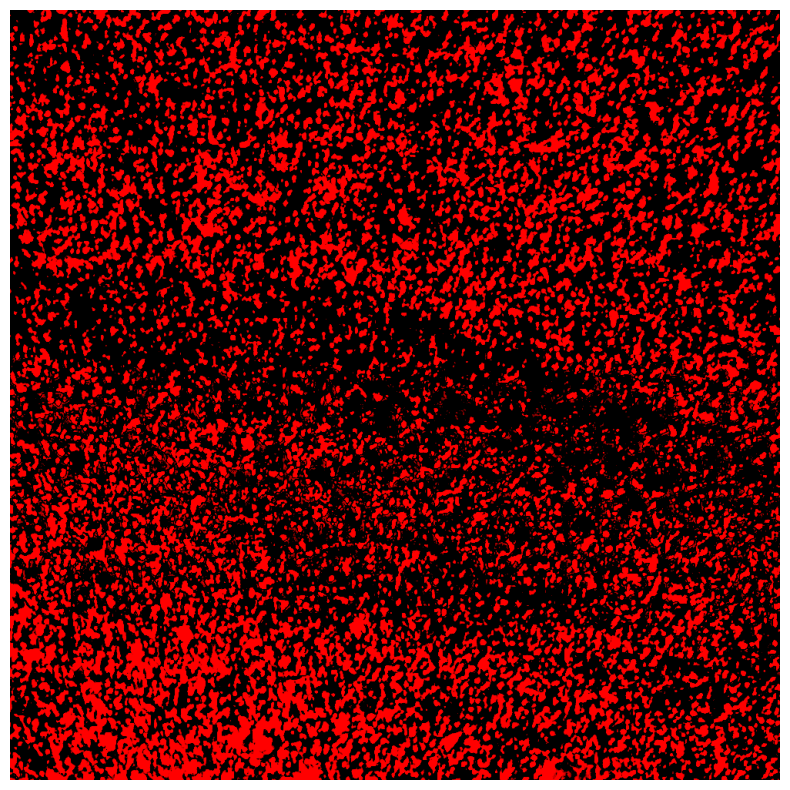

In [52]:
roi_manual = cv2.imread("roi-manual.png")
display_image(roi_manual)

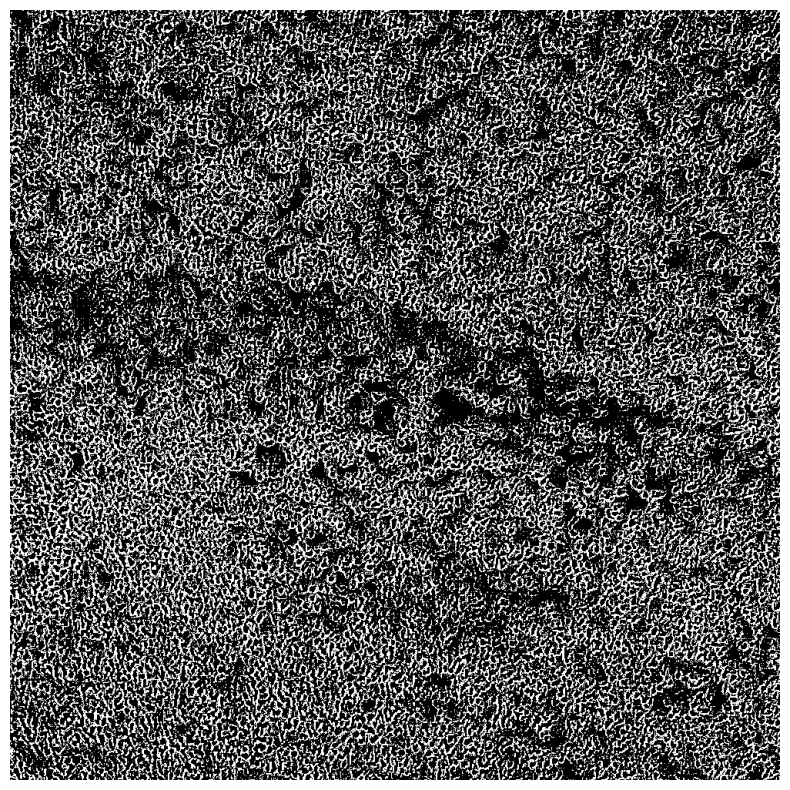

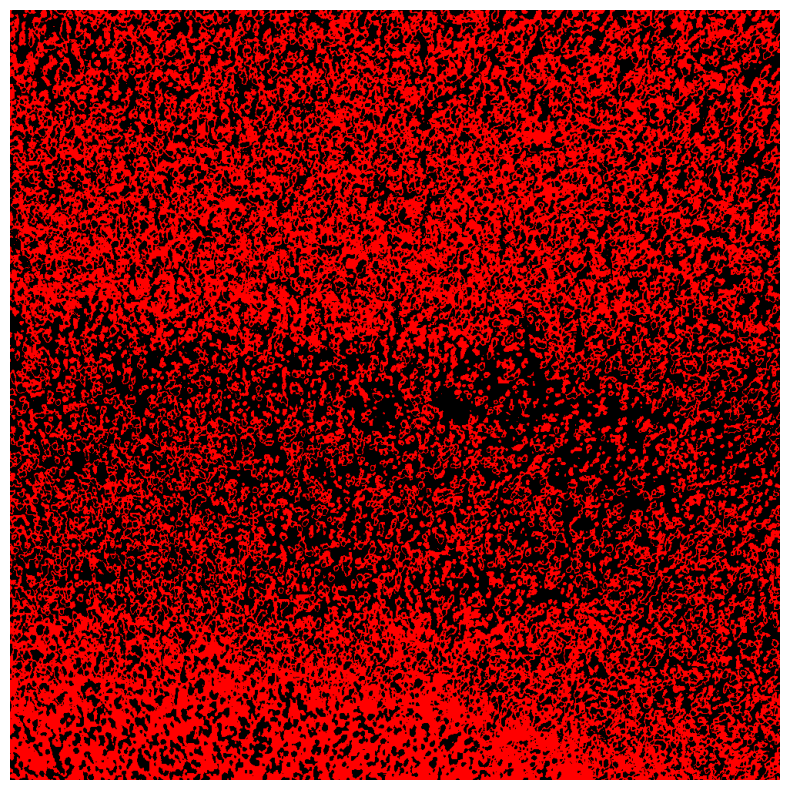

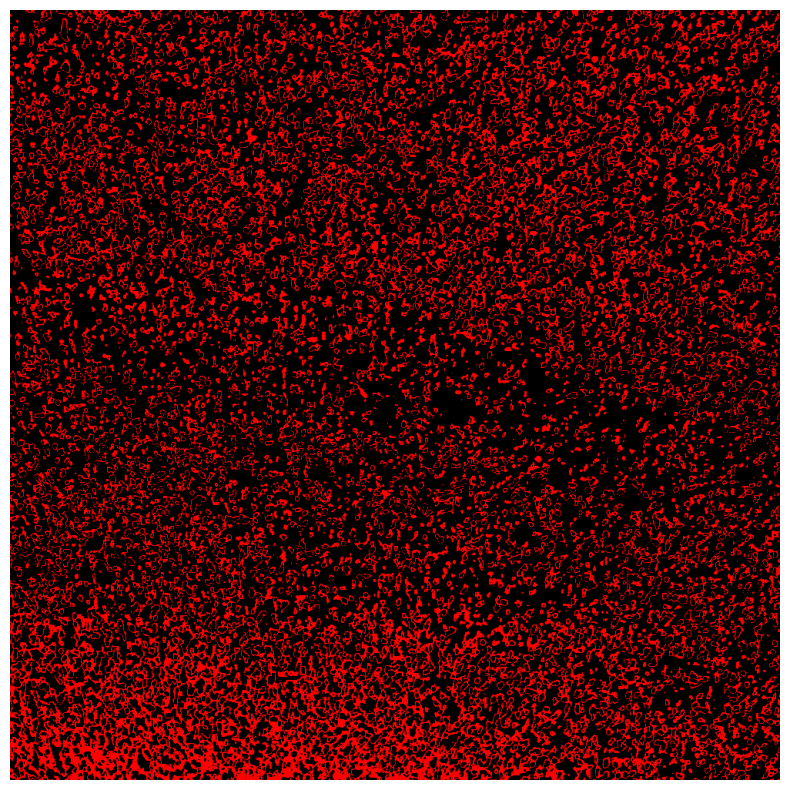

In [53]:
roi_brightness = brightness[2000:3000, 3000:4000]
roi_kmeans = kmeans[2000:3000, 3000:4000]
roi_dbscan = dbscan[2000:3000, 3000:4000]

# Display the ROIs
display_image(roi_brightness)
display_image(roi_kmeans)
display_image(roi_dbscan)

In [ ]:
def calculate_coverage(mask: np.ndarray):
    # Calculate the coverage percentage for each cluster
    coverage = np.sum(mask) / (mask.shape[0] * mask.shape[1]) * 100

    # Find contours in the mask
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Calculate the size of each contour
    areas = [cv2.contourArea(cnt) for cnt in contours]
    # Filter out large contours (non-particle clusters)
    areas_over_1000 = [area for area in areas if area > 1000]
    areas = [area for area in areas if area < 1000]
    
    # Get bins
    bins = np.array([1, 100, 250, 500, 1000])
    bin_counts, bin_edges = np.histogram(areas, bins=bins)

    # fig, ax = plt.subplots()
    # ax.hist(areas, bins=bin_edges, alpha=0.7, color="blue", edgecolor="black")
    # ax.set_title("Cluster Size Distribution")
    # ax.set_xlabel("Area (pixels)")
    # ax.set_ylabel("Frequency")
    # plt.tight_layout()
    # plt.savefig("cluster_size_distribution.png")
    # plt.close(fig)

    # Convert the histogram to a dictionary
    size_distribution = {
        f"{int(bin_edges[i])}-{int(bin_edges[i + 1])}": int(bin_counts[i])
        for i in range(len(bin_counts))
    }
    size_distribution.update(
        {"1000+": len(areas_over_1000)}
    )

    return {"coverage": coverage, "size_distribution": size_distribution}

In [68]:
def create_binary_mask(image: np.ndarray) -> np.ndarray:
    """
    Creates a binary mask where all non-black pixels in the image are set to 1.

    Args:
        image (np.ndarray): The input image.

    Returns:
        np.ndarray: A binary mask with the same height and width as the input image.
    """
    # Check if the image is grayscale or color
    if len(image.shape) == 2:  # Grayscale image
        mask = (image > 0).astype(np.uint8)
    else:  # Color image
        mask = (np.sum(image, axis=2) > 0).astype(np.uint8)

    return mask

roi_manual_mask = create_binary_mask(roi_manual)
roi_brightness_mask = create_binary_mask(roi_brightness)
roi_kmeans_mask = create_binary_mask(roi_kmeans)
roi_dbscan_mask = create_binary_mask(roi_dbscan)

In [69]:
# Calculate coverage for each ROI
print("MANUAL ROI CALULATION")
manual_coverage = calculate_coverage(roi_manual_mask)
print("Coverage: {:.2f}%".format(manual_coverage["coverage"]))
print("Size Distribution:")
for size, count in manual_coverage["size_distribution"].items():
    print(f"  {size}: {count}")

print("BRIGHTNESS ROI CALULATION")
brightness_coverage = calculate_coverage(roi_brightness_mask)
print("Coverage: {:.2f}%".format(brightness_coverage["coverage"]))
print("Size Distribution:")
for size, count in brightness_coverage["size_distribution"].items():
    print(f"  {size}: {count}")

print("KMEANS ROI CALULATION")
kmeans_coverage = calculate_coverage(roi_kmeans_mask)
print("Coverage: {:.2f}%".format(kmeans_coverage["coverage"]))
print("Size Distribution:")
for size, count in kmeans_coverage["size_distribution"].items():
    print(f"  {size}: {count}")

print("DBSCAN ROI CALULATION")
dbscan_coverage = calculate_coverage(roi_dbscan_mask)
print("Coverage: {:.2f}%".format(dbscan_coverage["coverage"]))
print("Size Distribution:")
for size, count in dbscan_coverage["size_distribution"].items():
    print(f"  {size}: {count}")

MANUAL ROI CALULATION
Coverage: 36.17%
Size Distribution:
  1-100: 3450
  100-250: 380
  250-500: 120
  500-1000: 55
  1000+: 22
BRIGHTNESS ROI CALULATION
Coverage: 57.11%
Size Distribution:
  1-100: 12
  100-250: 0
  250-500: 0
  500-1000: 0
  1000+: 1
KMEANS ROI CALULATION
Coverage: 48.91%
Size Distribution:
  1-100: 595
  100-250: 104
  250-500: 35
  500-1000: 14
  1000+: 12
DBSCAN ROI CALULATION
Coverage: 24.58%
Size Distribution:
  1-100: 3254
  100-250: 235
  250-500: 59
  500-1000: 20
  1000+: 8


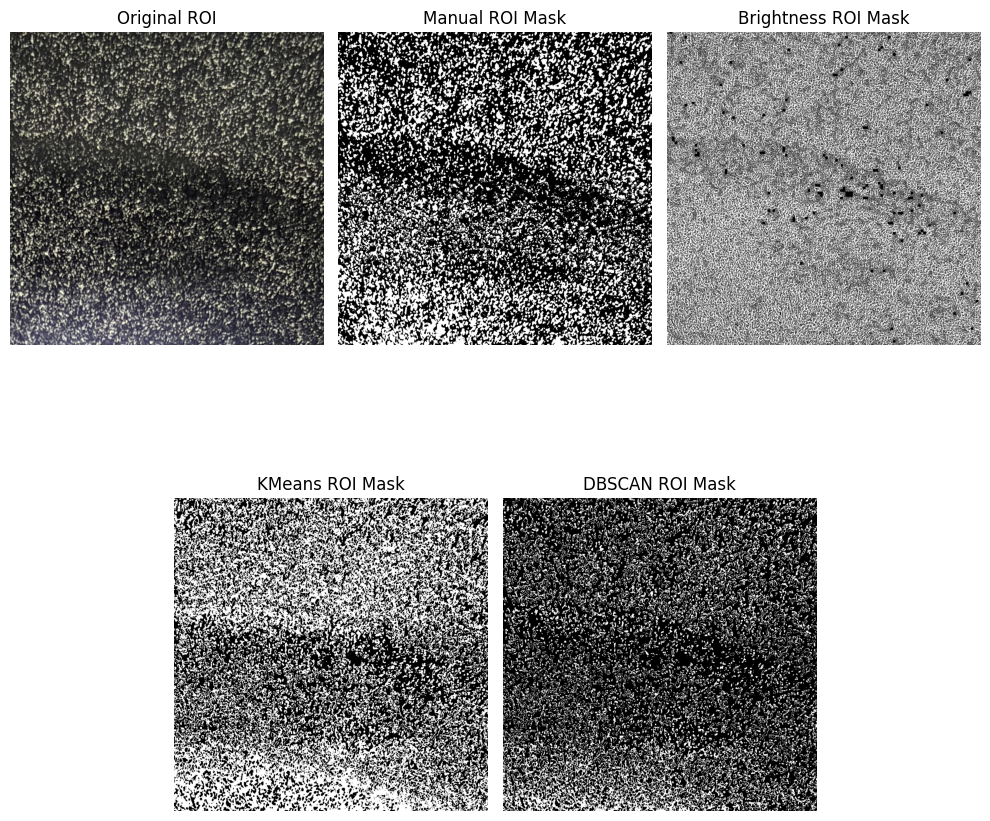

In [70]:
# Convert masks to 3-channel images for display
roi_manual_mask_3ch = cv2.merge([roi_manual_mask] * 3) * 255
roi_brightness_mask_3ch = cv2.merge([roi_brightness_mask] * 3) * 255
roi_kmeans_mask_3ch = cv2.merge([roi_kmeans_mask] * 3) * 255
roi_dbscan_mask_3ch = cv2.merge([roi_dbscan_mask] * 3) * 255


# Create a custom grid layout with 6 columns for better centering
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(2, 6, figure=fig)

# Top row (spans 2 columns each)
ax1 = fig.add_subplot(gs[0, 0:2])
ax1.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
ax1.set_title("Original ROI")
ax1.axis("off")

ax2 = fig.add_subplot(gs[0, 2:4])
ax2.imshow(cv2.cvtColor(roi_manual_mask_3ch, cv2.COLOR_BGR2RGB))
ax2.set_title("Manual ROI Mask")
ax2.axis("off")

ax3 = fig.add_subplot(gs[0, 4:6])
ax3.imshow(cv2.cvtColor(roi_brightness_mask_3ch, cv2.COLOR_BGR2RGB))
ax3.set_title("Brightness ROI Mask")
ax3.axis("off")

ax4 = fig.add_subplot(gs[1, 1:3])
ax4.imshow(cv2.cvtColor(roi_kmeans_mask_3ch, cv2.COLOR_BGR2RGB))
ax4.set_title("KMeans ROI Mask")
ax4.axis("off")

ax5 = fig.add_subplot(gs[1, 3:5])
ax5.imshow(cv2.cvtColor(roi_dbscan_mask_3ch, cv2.COLOR_BGR2RGB))
ax5.set_title("DBSCAN ROI Mask")
ax5.axis("off")

# Adjust layout and save
plt.tight_layout()
plt.savefig("roi_masks_comparison.png")